# Predictive Data Mining
IFN645 - Data Mining Technologies and Applications
Due date: 7th April, 2019

Before answering any questions we need to import the neccessary libraries and data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
df = pd.read_csv('./data.csv')

# Toggle whether or not to show output.
verbose = True
quick_mode = True
target_value = "IsBadBuy"

C:\Users\Schmidt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Task 1 - Data Selection and Distribution. 
#### 1.1 What is the proportion of cars who can be classified as a “kick”?
The proportion of *kicks* can be calculated using the function .mean() because the data is stored binary in the column *IsBadBuy*.  12.95% of the cars are *kicks* in the provided dataset.

In [2]:
if(verbose):
    print("Percentage of kicks: " + str(df[target_value].mean() * 100) + "%")

Percentage of kicks: 12.94965763333012%


#### 1.2 Did you have to fix any data quality problems? Detail them.
We found a bunch of data quality problems that we had to take care of.

Almost all data was missing on 44 of the rows, so we decided to remove them from the dataset. The percentage of *kicks* remained 12.95%.

In [3]:
c_name = "VehYear"
df[c_name] = df[c_name].fillna(0).astype(int)
if(verbose):
    print(df.loc[df[c_name] == 0])
df = df[df[c_name] != 0]

       PurchaseID  PurchaseTimestamp      PurchaseDate Auction  VehYear Make  \
20512       20512         1279065600  14/07/2010 10:00     NaN        0  NaN   
20513       20513         1279065600  14/07/2010 10:00     NaN        0  NaN   
20514       20514         1279065600  14/07/2010 10:00     NaN        0  NaN   
20515       20515         1279065600  14/07/2010 10:00     NaN        0  NaN   
20516       20516         1279065600  14/07/2010 10:00     NaN        0  NaN   
20676       20676         1286496000   8/10/2010 10:00     NaN        0  NaN   
20677       20677         1286496000   8/10/2010 10:00     NaN        0  NaN   
20678       20678         1286928000  13/10/2010 10:00     NaN        0  NaN   
20679       20679         1286928000  13/10/2010 10:00     NaN        0  NaN   
20680       20680         1286928000  13/10/2010 10:00     NaN        0  NaN   
20681       20681         1286928000  13/10/2010 10:00     NaN        0  NaN   
20682       20682         1286928000  13

Some columns required data cleaning. As we did not have a data/domain expert available we had to make some assumptions:
- *Manual* and *MANUAL* is assumed to be the same in the column *Transmission*.
- All values except 0 and 0.0 is assumed to be 1 in the column *IsOnlineSale*.
- *IsOnlineSale* should be represented as a binary value.
- *IsBadBuy* should be represented as binary value.
- All *MMR...* values should be interpreted as numbers, not strings.
- *WheelType* empty cells should be *?*.

['AUTO' 'MANUAL' 'Manual' '?']
['AUTO' 'MANUAL' '?']


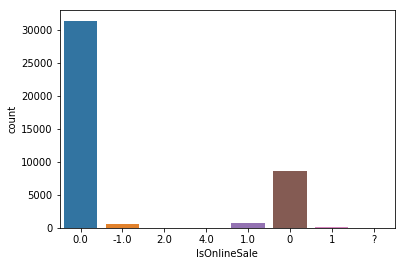

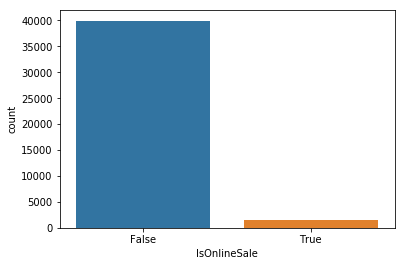

In [4]:
c_name = "Transmission"
if(verbose):
    print(df[c_name].unique())
df[c_name] = df[c_name].mask(df[c_name] == "Manual", "MANUAL")
if(verbose):
    print(df[c_name].unique())
    
c_name = "IsOnlineSale"
if(verbose):
    dg = sns.countplot(data=df, x=c_name)
    plt.show()

df[c_name] = df[c_name].mask(df[c_name] == 0.0, "0")
df[c_name] = np.where(df[c_name] == "0", False, True)

if(verbose):
    dg = sns.countplot(data=df, x=c_name)
    plt.show()
    
c_name = "IsBadBuy"
if(verbose):
    df[c_name].unique()
df[c_name] = df[c_name].astype(bool)
if(verbose):
    df[c_name].unique()
    
     
for c_name in ["MMRAcquisitionAuctionAveragePrice",
              "MMRAcquisitionAuctionCleanPrice",
              "MMRAcquisitionRetailAveragePrice",
              "MMRAcquisitonRetailCleanPrice",
              "MMRCurrentAuctionAveragePrice",
              "MMRCurrentAuctionCleanPrice",
              "MMRCurrentRetailAveragePrice",
              "MMRCurrentRetailCleanPrice",
              "MMRCurrentRetailRatio"]:
    df[c_name] = df[c_name].mask(df[c_name] == "?", 0)
    df[c_name] = df[c_name].mask(df[c_name] == "#VALUE!", 0)
    df[c_name] = pd.to_numeric(df[c_name])
    df[c_name] = df[c_name].mask(df[c_name] == 1, 0)
    
c_name = "WheelType"
df[c_name] = df[c_name].fillna("?")

#### 1.3 Can you identify any clear patterns by initial exploration of the data using histogram or box plot?
The *VehYear* column, the year in which the car was made - does seems to have a influence on the *IsBadBuy* varible.  
It is more likely that an older car is a *kick*.

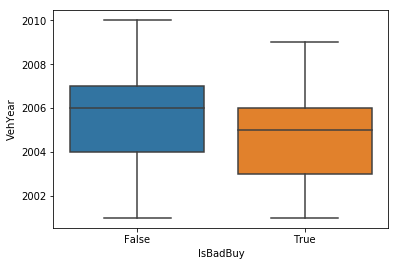

In [5]:
if(verbose):
    ax = sns.boxplot(x=target_value, y='VehYear', data=df)
    plt.show()

#### 1.4 What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.
We decided to drop the following columns:
- PurchaseID
- PurchaseTimestamp
- PurchasseData
- WheelTypeID
- PRIMEUNIT
- AUCGUART
- ForSale

Identification columns is not interesting. Almost all cars are marked as for sale. *PRIMEUNIT* and *AUCGUART* is missing data in most of the data entries.

In [6]:
df.drop(['PurchaseID','PurchaseTimestamp','PurchaseDate','WheelTypeID','PRIMEUNIT','AUCGUART','ForSale'],axis=1,inplace=True)

#### 1.5 What distribution scheme did you use? What data partitioning allocation did you set? Explain your selection.
The distribution between good and bad buys was very skewed, which made our prediction models have a heavy tendency to predict most cars as being good buys. We decided to use undersampling to counter the skewness - so the distribution between good and bay buys were equal in our traning sets.

## Task 2 - Predictive Modeling Using Decision Trees

In [7]:
# prepare data for decision tree
df_decision = pd.get_dummies(df)
df_decision = df_decision.dropna()

# target/input split
y = df_decision[target_value]
X = df_decision.drop([target_value],axis = 1)

# setting random state
rs = 10

# undersampling 
badBuy_indices = df_decision[df_decision[target_value] == 0].index

sample_size = sum(df_decision.IsBadBuy == 1)

random_indices = np.random.choice(badBuy_indices, sample_size, replace=False)

Non_badBuy_sample = df_decision.loc[random_indices]

Badbuys = df_decision.loc[df_decision[target_value]==1]

sample_data = Badbuys.append(Non_badBuy_sample,ignore_index=True)
X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

C:\Users\Schmidt\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


#### 2.1 Build a decision tree using the default setting. 
*(a) What is the classification accuracy on training and test datasets?*  
Full print-out provided below. 63%

*(b) What is the size of tree (i.e. number of nodes)?*  
Default settings gives a tree with 2617 nodes, tweaked has 53 nodes.

*(c) How many leaves are in the tree that is selected based on the validation dataset?*  
27 leaves in the tree with a total of 53 nodes.

*(d) Which variable is used for the first split? What are the competing splits for this first split?*  
Our tree first splits on *WheelType_?*, or in English words - weather the type of wheels on the car is known.
Another close contender is *VehYear*, the year the vechicle was manufactured.

*(e) What are the 5 important variables in building the tree?*  
- WheelType (unknown, boolean value)
- VehYear
- MMRAcquisitionAuctionCleanPrice
- MMRAcquisitionRetailAveragePrice
- MMRAcquisitionAuctionAveragePrice

*(f) Report if you see any evidence of model overfitting.*  
There is signs of overfitting for the default settings, but not on the tweaked tree.

*(g) Did changing the default setting (i.e., only focus on changing the setting of the number of splits to create a node) help improving the model? Answer the above questions on the best performing tree.*  
Changing **min_samples_leaf** had a negative effect on the results.  
Changing **max_depth** helped us get better result on the test data (minimized overfitting).

In [8]:
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
if(verbose):
    print("DEFAULT SETTINGS:")
    print(classification_report(y_test, y_pred))
    print("Number of nodes: " + str(model.tree_.node_count))

model = DecisionTreeClassifier(max_depth=5,random_state=rs)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
if(verbose):
    print("\nTWEAKED SETTINGS:")
    print(classification_report(y_test, y_pred))
    print("Number of nodes: " + str(model.tree_.node_count))

DEFAULT SETTINGS:
              precision    recall  f1-score   support

       False       0.62      0.64      0.63      1590
        True       0.63      0.61      0.62      1591

   micro avg       0.63      0.63      0.63      3181
   macro avg       0.63      0.63      0.63      3181
weighted avg       0.63      0.63      0.63      3181

Number of nodes: 2645

TWEAKED SETTINGS:
              precision    recall  f1-score   support

       False       0.65      0.71      0.68      1590
        True       0.68      0.62      0.65      1591

   micro avg       0.67      0.67      0.67      3181
   macro avg       0.67      0.67      0.66      3181
weighted avg       0.67      0.67      0.66      3181

Number of nodes: 53


In [9]:
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("week3_dt_viz.png") # saved in the following file - will return True if successful

True

#### 2.2 Build another decision tree tuned with GridSearchCV

In [12]:
quick_mode = False
if(quick_mode):
    print("Turn off quick mode to enable gridsearch.")
else:
    params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 10),
          'min_samples_leaf': range(20, 60, 10)}

    cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
    cv.fit(X_train, y_train)
    
    if(verbose):
        print("Train accuracy:", cv.score(X_train, y_train))
        print("Test accuracy:", cv.score(X_test, y_test))

    y_pred = cv.predict(X_test)
    if(verbose):
        print(classification_report(y_test, y_pred))

Train accuracy: 0.6896644657054305
Test accuracy: 0.6629990569003458
              precision    recall  f1-score   support

       False       0.65      0.72      0.68      1590
        True       0.68      0.61      0.64      1591

   micro avg       0.66      0.66      0.66      3181
   macro avg       0.66      0.66      0.66      3181
weighted avg       0.66      0.66      0.66      3181



*(a) What is the classification accuracy on training and test datasets?*  
The result is 69% on the training data and 66% on the test data. The full report is printed above.  

*(b) What is the size of tree (i.e. number of nodes)? Is the size different from the maximal tree or the tree in the previous step? Why?*  
It is way lower than the maximal tree - a maximal tree would not be very useful, it would be overfitting a lot. Also, our max_depth does not allow for the creation of a maximal tree. The previous tree contained 53 nodes and the optimized tree also contains 53 nodes.

*(c) How many leaves are in the tree that is selected based on the validation data set?*  
This tree contains 26 leaves (compared to 27 in the previous).

*(d) Which variable is used for the first split? What are the competing splits for this first split?*  
Same as previous tree, the type of the wheel.

*(e) What are the 5 important variables in building the tree?*
- WheelType_? (is wheel type unknown)
- VehYear
- MMRAcquisitionAuctionAveragePrice
- VehOdo
- TopThreeAmericanName_FORD (is the maker FORD)

*(f) Report if you see any evidence of model overfitting.*   
There is a slight overfitting, but very minimal.

*(g) What are the parameters used? Explain your choices.*  
We tried to test both the *gini* and *entropy* way of measuring quality of the split.  
*Max_depth* is varied to try to improve accuracy without overfitting the model and the *min_samples_leaf* to test if internal node splitting would result in a different and more accurate tree.

In [13]:
print("Number of nodes: " + str(model.tree_.node_count))

# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("opti.png") # saved in the following file - will return True if successful

# grab feature importances from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:5]

for i in indices:
    print(feature_names[i], ':', importances[i])

Number of nodes: 53
WheelType_? : 0.5794533546423895
VehYear : 0.1858645272704654
MMRAcquisitionAuctionAveragePrice : 0.10895355929167352
VehOdo : 0.029106195380610662
TopThreeAmericanName_FORD : 0.015964135526829685


#### 2.3 What is the significant difference do you see between these two decision tree models?
*How do they compare performance-wise? Explain why those changes may have happened.*
The performance change is insignificant. The two decision trees are almost the same.
This is probably caused by the most important configuration in this case being *max_depth* which we adjusted before running grid search to find parameters.

#### 2.4 From the better model, can you identify which cars could potential be *kicks*?

## Task 3 - Predictive Modeling Using Regression

In [11]:
sample_data.info()
sample_data.drop(['Transmission_AUTO','Transmission_MANUAL','Auction_OTHER','Auction_MANHEIM','Auction_ADESA'],axis=1,inplace=True)


X = sample_data.drop([target_value],axis = 1)
y = sample_data[target_value]

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

KeyError: "['PurchaseID' 'PurchaseTimestamp' 'PurchaseDate' 'WheelTypeID' 'PRIMEUNIT'\n 'AUCGUART' 'ForSale'] not found in axis"

#### 3.1 In preparation for regression, is any imputation of missing values needed for this data set? List the variables that did.
> 509 cars need *MMR___* data  
> 44 cars have already been removed due to missing information (year)

In [ ]:
if(verbose):
    print("\nThe following columns still have missing values:")
nan_list = list()
for c_name in list(sample_data):
    if(sample_data[c_name].isnull().values.any()):
        nan_list.append(c_name)
        if(verbose):
            print(c_name)

sample_data = sample_data.dropna(subset=nan_list) 

#### 3.2 Apply transformation method(s) to the variable(s) that need it. List the variables that needed it

In [ ]:
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(3,3, figsize=(10,10), sharex=False)

    sns.distplot(df['MMRAcquisitionAuctionAveragePrice'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['MMRAcquisitionAuctionCleanPrice'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['MMRAcquisitionRetailAveragePrice'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['MMRAcquisitonRetailCleanPrice'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['MMRCurrentAuctionAveragePrice'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['MMRCurrentAuctionCleanPrice'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['MMRCurrentRetailAveragePrice'].dropna(), hist=False, ax=axes[2,0])
    sns.distplot(df['MMRCurrentRetailCleanPrice'].dropna(), hist=False, ax=axes[2,1])
    sns.distplot(df['MMRCurrentRetailRatio'].dropna(), hist=False, ax=axes[2,2])

    plt.show()
    
plot_skewed_columns(df)

In [ ]:
# list columns to be transformed
columns_to_transform = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
                        'MMRAcquisitonRetailCleanPrice','MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice','MMRCurrentRetailRatio']

# copy the dataframe
df_log = sample_data.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
plot_skewed_columns(df_log)

In [ ]:
y_log = df_log[target_value]
X_log = df_log.drop([target_value], axis=1)

X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

#### 3.3 Build a regression model using the default regression method with all inputs.

In [ ]:
# fit it to training data
model = LogisticRegression(random_state=rs)
model.fit(X_train_log, y_train_log)

# classification report on test data
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))


y_pred = model.predict(X_test_log)
if(verbose):
    print(classification_report(y_test_log, y_pred))

#### 3.3 ... Once you done it, build another one and tune it using GridSearchCV

In [ ]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

print(cv.best_params_)

*(h) Name the regression function used.*  
Logistic regression was used to build the model.

*(i) How much was the difference in performance of two models build, default and optimal?*  
It is slightly improved as we can see the precision on True is 0.61 on default model but 0.62 on optimal model.

*(j) Show the set parameters for the best model. What are the parameters used?
Explain your decision. What are the optimal parameters?*  
The set parameters is based on GridSearchCV which tries different parameters from a typical range of values and pick the optimal ones. In sklearn logistic regression, regularisation is implemented in the hyperparameter C, which denotes the inverse of regularisation strength. Smaller C means stronger regularisation. The C for our best model is 1000.

*(k) Report which variables are included in the regression model.*  


In [ ]:
sample_data.info()

*(l) Report the top-5 important variables (in the order) in the model.*  
- MMRAcquisitionRetailAveragePrice
- MMRAcquisitionAuctionAveragePrice
- MMRCurrentRetailCleanPrice
- MMRCurrentAuctionAveragePrice
- MMRCurrentAuctionCleanPrice

*(m) What is classification accuracy on training and test datasets?*  

In [ ]:
print("Train accuracy:", model.score(X_train_log, y_train_log))
print("Test accuracy:", model.score(X_test_log, y_test_log))
print(classification_report(y_test_log, y_pred))

*(n) Report any sign of overfitting*
We can see the test accuracy is lower than train accuracy due to a slight overfitting.

#### 3.4 Build another regression model using the subset of inputs selected by RFE and selection by model method. Answer the followings:

In [ ]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs,solver = 'lbfgs'), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV



X_train_sel = rfe.transform(X_train_log)
X_test_sel = rfe.transform(X_test_log)

params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train_log))
print("Test accuracy:", cv.score(X_test_sel, y_test_log))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

*(a) Report which variables are included in the regression model.*
*(b) Report the top-5 important variables (in the order) in the model.*
c. What are the parameters used? Explain your choices. What are the optimal
parameters? Which regression function is being used?
d. Report any sign of overfitting.
e. What is classification accuracy on training and test datasets?
f. Did it improve/worsen the performance? Explain why those changes may
have happened.